# Modelos de Machine Learning 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import joblib


from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

from gensim.models import Word2Vec


## Importamos el Dataset

In [2]:
df_lem = pd.read_csv('../../cyberbullying/data/lem_classified_racism_tweets.csv')
df_lem.head()

,text,type
0,beepss senna beepss i m not sexist but fuck if...,gender
1,no you don t shut up jeff i thought of a reall...,gender
2,wateronatrain mt you might like this http t co...,gender
3,metalbarbiedoll but yea apparently gamergate w...,gender
4,d nkrause dudes who go to culinary school why ...,gender


In [3]:
df_lem.shape

(42270, 2)

In [4]:
percentage_used = 1
df_sample = df_lem.sample(frac=percentage_used, random_state=0)

In [5]:
from sklearn.preprocessing import LabelEncoder
label_enc=LabelEncoder()
df_sample['encoded_type']=label_enc.fit_transform(df_sample['type'])


In [6]:
df_sample

,text,type,encoded_type
16954,idiot koomuttai there are lakhs of temples in ...,religion,4
20206,miyata kurisu all of us right now,other,3
30032,nobody tells you that high school is harder th...,age,0
8522,making jokes about rape huh disgusting go fuck...,gender,2
35664,a white teenager called both negro and the n word,ethnicity,1
...,...,...,...
41993,you lazy dumb niggers have had s of years to g...,ethnicity,1
32103,i m not for victims of bullying going crazy an...,age,0
30403,instead they think having games of foot ball i...,age,0
21243,hagusp gabriella t i fucking know i was like w...,other,3


In [7]:
class_labels=label_enc.classes_
class_labels

array(['age', 'ethnicity', 'gender', 'other', 'religion'], dtype=object)

In [8]:
df_sample['encoded_type'].value_counts()

1    9832
2    8825
4    7982
0    7956
3    7675
Name: encoded_type, dtype: int64

## Holdout

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_sample['text'], df_sample['encoded_type'], test_size=0.3, random_state=0)

In [10]:
X_train

12185    dankmtl peacenothate she does to the idf hamas...
28501    this is what happens when you go through high ...
32002    u bully one white kid in ur school s christian...
7001     yeah the show is horrible comedy you can t rel...
38246    how to deal with dumb niggers like you qt nbe ...
                               ...                        
2195     jaykyew call me sexist but hearing a woman do ...
35252    i do wish you wouldn t cherry pick a tweet lik...
6451     gross ronaldinho has come out fiercely in supp...
5345     you never saw any celebrity say anything like ...
3102     doublebirdexit this lady is a terrible officia...
Name: text, Length: 29589, dtype: object

In [11]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
scorer = make_scorer(f1_score)

In [12]:
def scores(cv_results):
    score_results = {'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
    for key in score_results.keys():
        if key == 'time':
            score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
        else:
            score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
    return score_results

In [13]:
def conf_mx_all(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)
    
    TN = cm[0,0]
    TP = cm[1,1]
    FN = cm[1,0]
    FP = cm[0,1]
    
    recall = np.round_(TP/(TP+FN),3)
    precision = np.round_(TP/(TP+FP),3)
    accuracy = np.round_((TP+TN)/(TP+TN+FP+FN),3)
    F1= np.round((2*precision*recall)/(precision+recall), 3)
    
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"Accuracy: {accuracy}")
    print(f"F1-score: {F1}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
    disp.plot();
    
    return recall, precision, accuracy, F1

In [14]:
def pipeline(vectorizer_list, learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    def list_params(new_class):
        name = new_class.__class__.__name__
        default_class = eval(name + '()').get_params()
        new_class = new_class.get_params()

        new_dict = {}

        for key in new_class.keys():
            if new_class[key] != default_class[key]:
                new_dict[key] = new_class[key]
        return new_dict
    
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for vectorizer in vectorizer_list:
        
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        
    
        for learner in learner_list:
        
            # Store the learner name:
            results['Algorithm'] = learner.__class__.__name__

            # Fit the learner:
            start = time() # Get start time
            print("Training {}".format(learner.__class__.__name__))
            learner = learner.fit(X_train_vec, y_train)
            end = time() # Get end time

            # Store the training time
            results['Training Time'] = end - start

            start = time() # Get start time
            predictions_test = learner.predict(X_test_vec)
            predictions_train = learner.predict(X_train_vec)
            end = time() # Get end time

            # Store the prediction time
            results['Prediction Time'] = end - start

            results['Metrics: Test']=classification_report(y_test, predictions_test, target_names=label_enc.classes_)
            results['Metrics: Train']=classification_report(y_train, predictions_train, target_names=label_enc.classes_)

            # Compute the Accuracy on Test Set
            #results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

            # Compute the Accuracy on Training Set
            #results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

            # Compute the F1 Score on Test Set
            #results['F1 Score: Test'] = f1_score(y_test, predictions_test)

            # Compute the F1 Score on Training Set
            #results['F1 Score: Train'] = f1_score(y_train, predictions_train)

            # Compute the Precision on Test Set
            #results['Precision: Test'] = precision_score(y_test, predictions_test)

            # Compute the Precision on Training Set
            #results['Precision: Train'] = precision_score(y_train, predictions_train)

            # Compute the Recall on Test Set
            #results['Recall: Test'] = recall_score(y_test, predictions_test)

            # Compute the Recall on Training Set
            #results['Recall: Train'] = recall_score(y_train, predictions_train)

            # Success
            print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
            print('----------------------------------------------------')

            final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results


In [15]:
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier



In [16]:
%%time
# make a list of vectorizers
vectorizers = [TfidfVectorizer(min_df=10, max_df=0.8, max_features=20000, ngram_range=(1,2))]

# make a list of models
models = [AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=10),
          #XGBClassifier(max_depth=10, n_estimators=100, learning_rate=0.1, use_label_encoder=False)
         ] 


re = pipeline(vectorizers, models, X_train, y_train, X_test, y_test)
results = pd.DataFrame(re)

Training AdaBoostClassifier
Training AdaBoostClassifier finished in 2.31 sec
----------------------------------------------------
CPU times: user 5.14 s, sys: 1.11 ms, total: 5.14 s
Wall time: 5.14 s


In [17]:
results['Algorithm']

0    AdaBoostClassifier
Name: Algorithm, dtype: object

In [18]:
print(results['Metrics: Test'][0])

              precision    recall  f1-score   support

         age       0.98      0.99      0.98      2427
   ethnicity       0.91      0.80      0.85      2913
      gender       0.94      0.79      0.86      2652
       other       0.71      0.92      0.80      2317
    religion       0.85      0.88      0.86      2372

    accuracy                           0.87     12681
   macro avg       0.88      0.87      0.87     12681
weighted avg       0.88      0.87      0.87     12681



In [19]:
results

,Algorithm,Training Time,Prediction Time,Metrics: Test,Metrics: Train
0,AdaBoostClassifier,2.305662,0.094447,precision recall f1-score ...,precision recall f1-score ...


In [21]:
#print(results['Metrics: Test'][1])

## Word2vec

In [22]:
word2vec = Word2Vec(sentences=X_train, vector_size=32, window=5, min_count=5) # jupyter

In [23]:
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
#X_train_embed = embedding(word2vec, X_train)
#X_test_embed = embedding(word2vec, X_test)

In [24]:
#X_train_embed

In [25]:
y_train

12185    4
28501    0
32002    0
7001     2
38246    1
        ..
2195     2
35252    1
6451     2
5345     2
3102     2
Name: encoded_type, Length: 29589, dtype: int64

model=AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=10)

#model.fit(X_train_embed, y_train)


predictions_test = model.predict(X_test_embed)
predictions_train = model.predict(X_train_embed)


results_test=classification_report(y_test, predictions_test, target_names=label_enc.classes_)
results_train=classification_report(y_train, predictions_train, target_names=label_enc.classes_)


In [26]:
def get_best_model(model, type_):
    name = model[type_]
    params = model[f'{type_} Params']
    return eval(f'{name}(**{params})')

In [27]:
#best_vectorizer = get_best_model(results.iloc[0], 'Vectorizer')
#best_model = get_best_model(results.iloc[0], 'Algorithm')

In [28]:
#best_vectorizer

In [29]:
#best_model

In [30]:
def plot_scores(results):
    score_results = {'class_weight': [dic['class_weight'][0] for dic in results['Algorithm Params'].values],
                     'accuracy': results['accuracy'],
                     'precision': results['precision'],
                     'recall': results['recall'],
                     'f1': results['f1'],
                     'time': results['Training Time'] + results['Prediction Time']}
    
    score_results = pd.DataFrame(data=score_results).sort_values(by = 'class_weight').reset_index(drop = True)
    
    plt.figure(figsize=(12,6))
        
    plt.plot(score_results['class_weight'], score_results['recall'], c='r', label='recall')
    plt.plot(score_results['class_weight'], score_results['precision'], c='b', label='precision')    
    plt.plot(score_results['class_weight'], score_results['f1'], c='g', label='f1')
    plt.xlabel('class weight')
    plt.ylabel('score')
    plt.legend()
    plt.grid(alpha=0.3)
        
    #return score_results

In [31]:
#plot_scores(results)

In [32]:
#vectorizer = best_vectorizer
#model = best_model

In [33]:
#preprocessing = make_column_transformer(
#    (make_pipeline(vectorizer), 'text')
#)

In [34]:
#pipe = make_pipeline(
#    preprocessing,
#    model
#)

#pipe

In [35]:
#pipe.get_params()

In [36]:
#X_train = pd.DataFrame(data=X_train, columns=['text'])
#X_test = pd.DataFrame(data=X_test, columns=['text'])

In [37]:
#cv_results = cross_validate(pipe, X_train, y_train, cv=5, n_jobs=-1, scoring=scoring)

In [38]:
#scores(cv_results)

In [39]:
#pipe.fit(X_train, y_train);

In [40]:
#y_pred = pipe.predict(X_test)

In [41]:
#conf_mx_all(y_test, y_pred)

In [42]:
params = {
    'columntransformer__pipeline__tfidfvectorizer__min_df': np.arange(5, 11),
    'linearsvc__C': np.arange(0.8, 1.3, 0.1),
    'linearsvc__class_weight': [{0: weight_0, 1: 1-weight_0} for weight_0 in np.arange(0.17, 0.24, 0.01)]
    
}

In [43]:
params = {
    'columntransformer__pipeline__tfidfvectorizer__min_df': np.arange(5, 11),
    'linearsvc__C': np.arange(0.9, 1.2, 0.1),
    'linearsvc__class_weight': [{0: weight_0, 1: 1-weight_0} for weight_0 in np.arange(0.18, 0.24, 0.01)],
    'linearsvc__dual': [False]
}

In [44]:
#search = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, scoring='f1')

In [45]:
%%time
#search.fit(X_train, y_train)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


In [46]:
#search.best_params_

In [47]:
#best_estimator = search.best_estimator_

In [48]:
#y_pred = best_estimator.predict(X_test)

In [49]:
#y_train.sum()

In [50]:
#y_train.mean()

In [51]:
#conf_mx_all(y_test, y_pred)

In [52]:
#lista = ['you fucking retard', 'asshole', 'stupid bitch', 'hello!',
#        "ns he can use and practice with. I can't say much more coz I don't have more space. Retard. This is all we need an Australian version of 1 Direction.... my dick was bleeding from how hard I was masturbating to this",
#        ]
#lista = pd.DataFrame(data=lista, columns=['text'])

#best_estimator.predict(lista)

In [53]:
#X_train_vec = best_vectorizer.fit_transform(X_train['text'])
#X_test_vec = best_vectorizer.transform(X_test['text'])

In [54]:
def tune_threshold(C=1):
    score_results = {'class_weight': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'time': []}
    
    def scores2(cv_results, class_weight):
        score_results = {'class_weight': None, 'accuracy': None, 'precision': None, 'recall': None, 'f1': None, 'time': None}
        for key in score_results.keys():
            if key == 'class_weight':
                score_results[key] = class_weight
            elif key == 'time':
                score_results[key] = round(cv_results['fit_time'].mean() + cv_results['score_time'].mean(), 1)
            else:
                score_results[key] = round(cv_results[f'test_{key}'].mean(), 4)
        return score_results
    
    for class_weight in np.arange(0.05, 0.3, 0.05):
        print(class_weight)
        
        cv_results = cross_validate(LinearSVC(C=C, class_weight={0:class_weight, 1:1-class_weight}),
                                    X_train_vec, y_train, cv=5, n_jobs=-1,
                                    scoring=['accuracy', 'precision', 'recall', 'f1'])

        score_results_new = scores2(cv_results, class_weight)
        
        for key in score_results.keys():
            score_results[key].append(score_results_new[key])
            
        
    plt.figure(figsize=(12,6))
        
    plt.plot(score_results['class_weight'], score_results['recall'], c='r', label='recall')
    plt.plot(score_results['class_weight'], score_results['precision'], c='b', label='precision')    
    plt.plot(score_results['class_weight'], score_results['f1'], c='g', label='f1')
    plt.xlabel('class weight')
    plt.ylabel('score')
    plt.legend()
    plt.grid(alpha=0.3)
        
    return score_results

In [55]:
#tune_threshold()

In [56]:
#tune_threshold(C=0.25)

In [57]:
#tune_threshold(C=0.5)

In [58]:
#tune_threshold(C=0.75)

# ESTE ES EL MODELO QUE VAMOS A USAR

In [59]:
vectorizer = TfidfVectorizer(min_df=10,max_df=0.8,max_features=25000, ngram_range=(1,2),)

# make a list of models
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                               n_estimators=10)

In [60]:
X_train_vec=vectorizer.fit_transform(X_train)
X_test_vec=vectorizer.transform(X_test)

In [61]:
X_train

12185    dankmtl peacenothate she does to the idf hamas...
28501    this is what happens when you go through high ...
32002    u bully one white kid in ur school s christian...
7001     yeah the show is horrible comedy you can t rel...
38246    how to deal with dumb niggers like you qt nbe ...
                               ...                        
2195     jaykyew call me sexist but hearing a woman do ...
35252    i do wish you wouldn t cherry pick a tweet lik...
6451     gross ronaldinho has come out fiercely in supp...
5345     you never saw any celebrity say anything like ...
3102     doublebirdexit this lady is a terrible officia...
Name: text, Length: 29589, dtype: object

In [62]:
X_train_vec

<29589x12352 sparse matrix of type '<class 'numpy.float64'>'
	with 833570 stored elements in Compressed Sparse Row format>

In [63]:
cv_results = cross_validate(model, X_train_vec, y_train, cv=5, n_jobs=-1)
cv_results

{'fit_time': array([2.31059194, 2.35242295, 2.32735705, 2.31723762, 2.35902762]),
 'score_time': array([0.02346015, 0.02383971, 0.0265851 , 0.02820253, 0.02529311]),
 'test_score': array([0.85366678, 0.85518756, 0.85147009, 0.86684691, 0.85837418])}

In [64]:
model.fit(X_train_vec,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=10)

In [65]:
prediction_test=model.predict(X_test_vec)
prediction_test

array([1, 3, 3, ..., 4, 4, 3])

In [66]:
print(classification_report(y_test, prediction_test, target_names=label_enc.classes_))

              precision    recall  f1-score   support

         age       0.98      0.99      0.99      2427
   ethnicity       0.91      0.80      0.85      2913
      gender       0.94      0.79      0.86      2652
       other       0.71      0.92      0.80      2317
    religion       0.85      0.88      0.86      2372

    accuracy                           0.87     12681
   macro avg       0.88      0.87      0.87     12681
weighted avg       0.88      0.87      0.87     12681



In [67]:
text=df_sample.iloc[1500]
text

text            randi at http t co dr fqxkymq
type                                    other
encoded_type                                3
Name: 20479, dtype: object

In [68]:
text['text']

'randi at http t co dr fqxkymq'

In [69]:
text_vec=vectorizer.transform([text['text']])
prediction=class_labels[model.predict(text_vec)]
prediction[0]

'other'

In [70]:
df_sample[['text','type']]

,text,type
16954,idiot koomuttai there are lakhs of temples in ...,religion
20206,miyata kurisu all of us right now,other
30032,nobody tells you that high school is harder th...,age
8522,making jokes about rape huh disgusting go fuck...,gender
35664,a white teenager called both negro and the n word,ethnicity
...,...,...
41993,you lazy dumb niggers have had s of years to g...,ethnicity
32103,i m not for victims of bullying going crazy an...,age
30403,instead they think having games of foot ball i...,age
21243,hagusp gabriella t i fucking know i was like w...,other


In [71]:
preprocessing = make_column_transformer(
    (make_pipeline(vectorizer), 'text')
)


pipe = make_pipeline(
    preprocessing,
    model
)

pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('tfidfvectorizer',
                                                                   TfidfVectorizer(max_df=0.8,
                                                                                   max_features=25000,
                                                                                   min_df=10,
                                                                                   ngram_range=(1,
                                                                                                2)))]),
                                                  'text')])),
                ('adaboostclassifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                    n_estimators=10))])

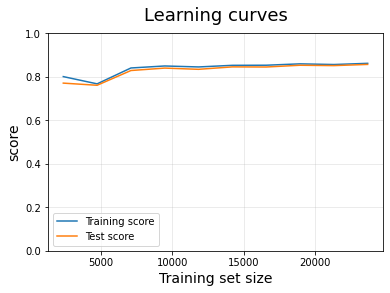

In [75]:
from sklearn.model_selection import learning_curve


train_sizes = np.linspace(.1,  1, 10)
# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, X=X_train_vec, y=y_train, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend();